# **Q3 - Assignment 3**

Student: Huyen Thi Thu Pham

[Here](https://colab.research.google.com/drive/1VkfLxIM1q3WF7RxeHD9vVxSDkg_6k7gH#scrollTo=fOLDXMV3NMEX) is the link to colab.

In [ ]:
# Mount Google Drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Clean reinstall compatible core packages
!pip uninstall -y numpy pandas scipy

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3


In [ ]:
#  Install compatible core packages
!pip install numpy==1.26.4 pandas==2.2.2 scipy==1.11.4

#  Install PyTorch 2.2.0 + cu121 (compatible with torchvision 0.17.0)
!pip install torch==2.2.0+cu121 torchvision==0.17.0+cu121 \
    -f https://download.pytorch.org/whl/torch_stable.html

#  Install PyTorch Geometric & extensions (cu121 version matches torch)
!pip install torch-scatter torch-sparse torch-cluster torch-geometric \
    -f https://data.pyg.org/whl/torch-2.2.0+cu121.html

#  Install extra packages
!pip install scikit-learn matplotlib networkx python-louvain node2vec


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 102.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 121.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 15.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.11.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.3/757.3 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 77.8 MB/s eta 

In [ ]:
#!pip uninstall -y thinc tsfresh

In [ ]:
# Restart runtime (Runtime > Restart runtime) and then run this

import torch
import numpy as np
import pandas as pd

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)


Torch: 2.2.0+cu121
CUDA available: True
NumPy: 1.26.4
Pandas: 2.2.2


In [ ]:
# Install required packages:

# Data manipulation and analysis
import pandas as pd
import numpy as np
from collections import Counter

# Network analysis
import networkx as nx
from networkx.algorithms.community import girvan_newman
from node2vec import Node2Vec
import community as community_louvain
from scipy.spatial.distance import cdist

# Machine learning
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Deep learning
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Utility
import os
import random
import datetime
from timeit import default_timer as timer
from collections import defaultdict

# Evaluation Metrics
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, confusion_matrix

# Dimensionality Reduction
from sklearn.decomposition import PCA

# Data Structures for Overlap Calculation
from collections import defaultdict

<mark>**Read Subset with 2000 Nodes**</mark>


In [ ]:
# Read the GEXF file using NetworkX:

sampled_G = nx.read_gexf("/content/drive/MyDrive/Colab Notebooks/DWSMA/Assignment3/sampled_graph_2000nodes.gexf")
print(f"Initial graph has {sampled_G.number_of_nodes()} nodes and {sampled_G.number_of_edges()} edges")

Initial graph has 2000 nodes and 3531 edges


In [ ]:
# Explore Basic Properties to understand the network structure:
print("Is directed:", nx.is_directed(sampled_G))
print("Number of nodes:", sampled_G.number_of_nodes())
print("Number of edges:", sampled_G.number_of_edges())

avg_in_deg = sum(dict(sampled_G.in_degree()).values()) / sampled_G.number_of_nodes()
avg_out_deg = sum(dict(sampled_G.out_degree()).values()) / sampled_G.number_of_nodes()

print("Average in-degree:", avg_in_deg)
print("Average out-degree:", avg_out_deg)


Is directed: True
Number of nodes: 2000
Number of edges: 3531
Average in-degree: 1.7655
Average out-degree: 1.7655


# **a. Apply the Girvan_Newman ALgorithmn for community detection**

The Girvan-Newman algorithm is a divisive community detection method that works by iteratively removing edges with the highest betweenness centrality, thereby breaking the graph into communities. For a directed graph like our subreddit hyperlink network, The standard `girvan_newman` implementation in NetworkX operates on undirected graphs. Converting the graph ensures compatibility and allows the algorithm to focus on general connectivity between subreddits, regardless of the direction of the hyperlink.

In [ ]:
# 1. Convert directed graph to undirected before applying Girvan-Newman
undirected_G = sampled_G.to_undirected()
print(f"Number of nodes and edges in undirected graph: {undirected_G.number_of_nodes()}, and: {undirected_G.number_of_edges()}")


# 2. Apply the Girvan-Newman algorithm to detect communities
communities_generator = girvan_newman(undirected_G)

# Get the first split of communities from the generator
# This represents the initial, broad community structure detected.
top_level_communities = next(communities_generator)

# Convert the communities from frozensets (output by NetworkX) to lists for easier handling and inspection.
top_level_communities = [list(community) for community in top_level_communities]

print(f"\n--- Girvan-Newman First Split Results ---")
print(f"Number of communities detected in the first split: {len(top_level_communities)}")
print("Example of detected communities (first 2 communities):")

# Print a summary of the first two communities, showing their size and a few members.
for i, community in enumerate(top_level_communities[:2]):
    print(f"Community {i + 1}: {community[:5]}... [Total members: {len(community)}]")


Number of nodes and edges in undirected graph: 2000, and: 3197

--- Girvan-Newman First Split Results ---
Number of communities detected in the first split: 1289
Example of detected communities (first 2 communities):
Community 1: ['thehound']... [Total members: 1]
Community 2: ['socialistbs', 'the_jews_did_this', 'deathmetal', 'metal_me_irl', 'merval']... [Total members: 691]


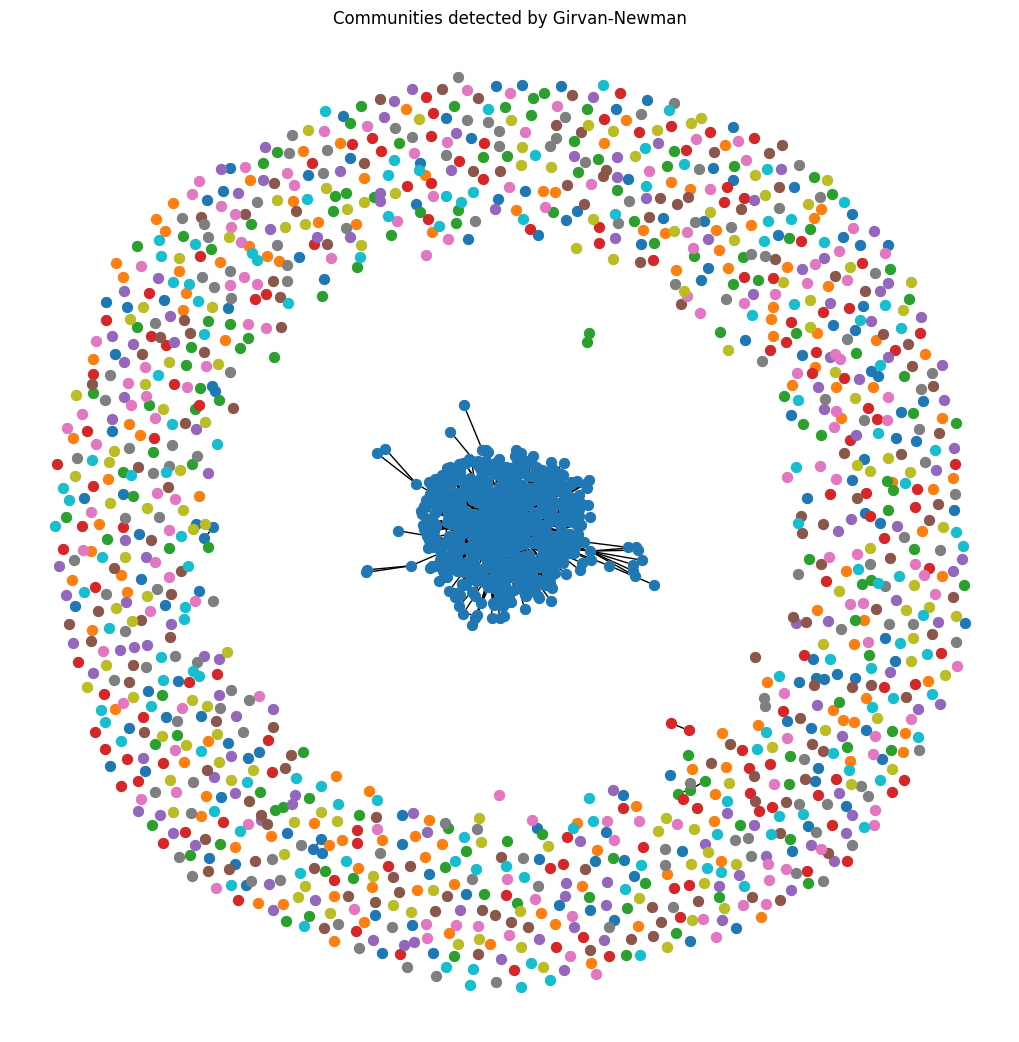

In [ ]:
# 3. Visualize the Communities:
# Use the undirected graph for layout consistency
pos = nx.spring_layout(undirected_G)

# Create the base plot with all nodes in light blue
plt.figure(figsize=(10, 10))
nx.draw(undirected_G, pos, node_color='lightblue', node_size=50, with_labels=False)

# Overlay each community with a unique color
colors = plt.colormaps.get_cmap('tab10').resampled(len(top_level_communities))
for i, community in enumerate(top_level_communities):
    nx.draw_networkx_nodes(undirected_G, pos, nodelist=community,
                           node_color=[colors(i)], node_size=50)

# Add title and display the plot
plt.title("Communities detected by Girvan-Newman")
plt.show()

In [ ]:
# 4. Hierarchical Community Structure- examine how the network can be divided into communities at multiple levels.

# Define the function to generate hierarchical communities with a given number of levels
def hierarchical_communities(G, levels=3):
    # Use the Girvan-Newman algorithm to generate hierarchical communities
    communities_generator = nx.community.girvan_newman(G)
    for _ in range(levels):
        communities = next(communities_generator)
        yield communities

# Iterate through hierarchical community levels
for i, communities in enumerate(hierarchical_communities(undirected_G)):
    # Print the level and number of communities
    print(f"Level {i+1}: {len(communities)} communities")

    # Print a summary of the community sizes at the first level
    if i == 0:
        community_sizes = [len(community) for community in communities]  # Get sizes of communities
        print(f"  Summary of Community Sizes (Level {i+1}):")
        print(f"    Total communities: {len(communities)}")
        print(f"    Average community size: {sum(community_sizes) / len(community_sizes):.2f}")
        print(f"    Largest community size: {max(community_sizes)}")
        print(f"    Smallest community size: {min(community_sizes)}")

    # For deeper levels, provide summary without individual community details
    else:
        print(f"  Level {i+1} Summary: {len(communities)} communities with varying sizes.")

Level 1: 1289 communities
  Summary of Community Sizes (Level 1):
    Total communities: 1289
    Average community size: 1.55
    Largest community size: 691
    Smallest community size: 1
Level 2: 1290 communities
  Level 2 Summary: 1290 communities with varying sizes.
Level 3: 1291 communities
  Level 3 Summary: 1291 communities with varying sizes.


<mark>**Create a DataFrame to store the community assignments**</mark>

In [ ]:
# Sort communities by their size (length) in descending order
top_level_communities_sorted_by_size = sorted(top_level_communities, key=len, reverse=True)

# Slice the first 4 largest communities
top_level_communities_4 = top_level_communities_sorted_by_size[:4]

# Create a DataFrame to store the community assignments
gn_labels = []
for i, community in enumerate(top_level_communities_4):
    for node in community:
        gn_labels.append((node, i))  # Assign community index as the label

df_gn = pd.DataFrame(gn_labels, columns=['Node ID', 'GN Cluster'])

# Get the array of unique clusters
unique_clusters = df_gn['GN Cluster'].unique()

# Print the number of clusters and the clusters themselves
print(f"Number of clusters: {len(unique_clusters)}")
print(f"Clusters: {unique_clusters}")

# Print the first few rows to verify
print(df_gn.head())

Number of clusters: 4
Clusters: [0 1 2 3]
             Node ID  GN Cluster
0        socialistbs           0
1  the_jews_did_this           0
2         deathmetal           0
3       metal_me_irl           0
4             merval           0


# **b. Create embedding using Node2Vec**
### **1.Graph Preprocessing**
<mark>**Check and Remove Isolated Nodes**</mark>

Isolated nodes do not contribute meaningful information to most graph algorithms, including community detection, centrality measures, or embeddings. Removing them helps reduce the graph size and focuses the analysis on the **connected components**.

In [ ]:
# Create a mutable copy of the graph:
sampled_G = sampled_G.copy()  # Unfreeze the graph for modifications

# Check for isolated nodes:
isolated_nodes = list(nx.isolates(sampled_G))  # Find isolated nodes (nodes with no connections)
print(f"Number of isolated nodes: {len(isolated_nodes)}")

# If there are isolated nodes, remove them from the graph:
if isolated_nodes:
    sampled_G.remove_nodes_from(isolated_nodes)  # Remove isolated nodes
    print(f"Graph after removing isolated nodes has {sampled_G.number_of_nodes()} nodes and {sampled_G.number_of_edges()} edges")

Number of isolated nodes: 1274
Graph after removing isolated nodes has 726 nodes and 3531 edges


<mark>**Ensure Edge Weights are Non-Negative**</mark>

check for any negative weights and reset them to **small positive values** (1 in this case).

In [ ]:
# Ensure edge weights are non-negative:

# Iterate through all edges in the graph and check their weights:
for u, v, d in sampled_G.edges(data=True):
    if d.get('weight', 1) < 0:  # If an edge has a negative weight
        sampled_G[u][v]['weight'] = 1  # Set the weight to 1 (a small positive value)

# Print important information:
print(f"Graph after edge weight adjustment has {sampled_G.number_of_nodes()} nodes and {sampled_G.number_of_edges()} edges")

Graph after edge weight adjustment has 726 nodes and 3531 edges


<mark>**Ensure the Graph is Connected**</mark>

We convert the graph to **undirected form** (since connectivity is often considered undirected) and check if it's connected. If it's not, we extract the **largest connected component** using NetworkX's `connected_components` function, ensuring that the new subgraph includes only nodes from this component.

In [ ]:
# Ensure the graph is connected:
# Convert the graph to undirected form and check if it is connected:
if not nx.is_connected(sampled_G.to_undirected()):

    # Get all connected components:
    connected_components = list(nx.connected_components(sampled_G.to_undirected()))
    num_components = len(connected_components)  # Total number of components

    # Get the largest connected component (subgraph with the most nodes):
    largest_cc = max(connected_components, key=len)

    # Calculate the number of nodes and edges before taking the largest connected component:
    original_num_nodes = sampled_G.number_of_nodes()
    original_num_edges = sampled_G.number_of_edges()

    # Extract the subgraph corresponding to the largest connected component:
    sampled_G = sampled_G.subgraph(largest_cc).copy()

    # Calculate the number of nodes and edges in the largest connected component:
    final_num_nodes = sampled_G.number_of_nodes()
    final_num_edges = sampled_G.number_of_edges()

    # Calculate the number of nodes and edges that were lost:
    lost_nodes = original_num_nodes - final_num_nodes
    lost_edges = original_num_edges - final_num_edges

    # Print a more detailed message:
    print(f"Graph originally had {original_num_nodes} nodes and {original_num_edges} edges.")
    print(f"After taking the largest connected component, {num_components - 1} disconnected components were removed.")
    print(f"{lost_nodes} nodes and {lost_edges} edges were discarded.")
    print(f"Largest connected component now has {final_num_nodes} nodes and {final_num_edges} edges.")
else:
    print("Graph is already connected.")

Graph originally had 726 nodes and 3531 edges.
After taking the largest connected component, 13 disconnected components were removed.
28 nodes and 17 edges were discarded.
Largest connected component now has 698 nodes and 3514 edges.


### **2. Node2Vec Model Initialization and Fitting**



We want Node2Vec to **explore more distant nodes** and **capture the overall graph structure**, this mean we want to bias its random walks to behave more like a **depth-first search (DFS)**, encouraging exploration farther from the starting node rather than just nearby neighbors, controlled by two parameters:
- **Increase the Return parameter $p$**: Controls the likelihood of returning to the previous node.
>- Set p > 1 (e.g., p = 2.0):
This discourages the walk from immediately returning to the node it just came from, pushing the walk to move forward.
- **Decrease the In-out parameter $q$**: Controls the likelihood of visiting nodes that are closer or further from the source node.
>- Set q < 1 (e.g., q = 0.5)
This encourages the random walk to explore nodes further away rather than staying close, favoring outward moves over staying local.



In [ ]:
# Generate node embeddings using Node2Vec with custom p and q values

node2vec = Node2Vec(sampled_G,
                    dimensions=64,  #Each node is represented as a 64-dimensional vector.
                    walk_length=30, #The number of steps per random walk.
                    num_walks=200,  #Perform 200 random walks for each node.
                    workers=4,      #Use 4 CPU cores for parallel computation.
                    p=2,            #Return hyperparameter controlling the likelihood of revisiting a node.
                    q=0.5)          #In-out parameter controlling the likelihood of exploring further from the starting node.

# Fit the Node2Vec model to learn embeddings
model = node2vec.fit()

# Node2Vec embeddings are generated and ready for downstream analysis
print("Node2Vec embeddings generated.")

# Get embeddings for each node

# Extract embeddings for each node in the graph using the trained Node2Vec model.
# The embeddings are stored as a numpy array where each row represents a node's vector for clustering.
# model.wv stores the learned embeddings for the nodes.
# str(node) ensures we are accessing embeddings for nodes represented as strings.

embeddings = np.array([model.wv[str(node)] for node in sampled_G.nodes()])

# Print the shape of the embeddings matrix to verify:
# The shape will be (number of nodes, embedding dimension), e.g., (1000, 64)
print(f"Embeddings shape: {embeddings.shape}")

Computing transition probabilities:   0%|          | 0/698 [00:00<?, ?it/s]

Node2Vec embeddings generated.
Embeddings shape: (698, 64)


# **Apply K-means clustering using the node embeddings to find 4 communities**

In [ ]:
# Apply K-means clustering on the embeddings

# Define the number of clusters as 4.
n_clusters = 4

# Print the number of clusters to be applied.
print(f"Applying K-means clustering with {n_clusters} clusters...")

# Initialize and fit the K-means model on the node embeddings.
# The 'random_state=42' ensures reproducibility of the results.
kmeans = KMeans(n_clusters=n_clusters, random_state=42,n_init=10) ## n_init to run K-means multiple times
kmeans_labels = kmeans.fit_predict(embeddings) # `embeddings` from partb

# Print a confirmation message after clustering is completed.
print("K-means clustering with 4 clusters completed.")

Applying K-means clustering with 4 clusters...
K-means clustering with 4 clusters completed.


<mark>**Create DataFrames**</mark>

In [ ]:
# Create a DataFrame with node IDs and their assigned cluster labels
node_ids = list(sampled_G.nodes())  # Get the node IDs from the graph
cluster_labels = kmeans_labels      # The cluster labels from K-means clustering

# Create a DataFrame to display the contents of each cluster
df_clusters = pd.DataFrame({
    'Node ID': node_ids,
    'Cluster': cluster_labels
})

# Sort the DataFrame by cluster for better readability
df_clusters_sorted = df_clusters.sort_values(by='Cluster')

# Display nodes in each cluster
for cluster in df_clusters_sorted['Cluster'].unique():
    print(f"Nodes in Cluster {cluster}:")
    cluster_content = df_clusters_sorted[df_clusters_sorted['Cluster'] == cluster]
    print(cluster_content)
    print("\n")  # Add a new line for better readability between clusters



Nodes in Cluster 0:
              Node ID  Cluster
543     jeremyolander        0
546         heavyseas        0
553         birdteams        0
555               c64        0
498       botrequests        0
..                ...      ...
77   civsaudisinaudis        0
19          med_humor        0
666     veryexpensive        0
675    srsprogramming        0
81     randomkindness        0

[110 rows x 2 columns]


Nodes in Cluster 1:
              Node ID  Cluster
637      homesteading        1
640     thedearhunter        1
26     motorcycleporn        1
40           thefence        1
43      worldbuilding        1
..                ...      ...
96    imagesofgeorgia        1
97                vim        1
681  characterdrawing        1
682      askreddit_ja        1
0    liberalgunowners        1

[85 rows x 2 columns]


Nodes in Cluster 2:
           Node ID  Cluster
672   biochemistry        2
673   vincent21212        2
674          music        2
676   bitcoinmusic        2
653  

In [ ]:
# Create a DataFrame with Node2Vec K-means results:
df_node2vec_kmeans = pd.DataFrame({
    'Node ID': list(sampled_G.nodes()),
    'Node2Vec_Kmeans_Cluster': kmeans_labels
})

# Get the array of unique clusters
unique_clusters = df_node2vec_kmeans['Node2Vec_Kmeans_Cluster'].unique()

# Print the number of clusters and the clusters themselves
print(f"Number of clusters: {len(unique_clusters)}")
print(f"Clusters: {unique_clusters}")

# Print the first few rows to verify
print(df_node2vec_kmeans.head())


# Convert Node2Vec embeddings and labels to a DataFrame
df_embeddings_node2vec = pd.DataFrame(embeddings)
df_embeddings_node2vec['Kmeans_Cluster'] = kmeans_labels  # Add cluster labels

Number of clusters: 4
Clusters: [1 3 0 2]
            Node ID  Node2Vec_Kmeans_Cluster
0  liberalgunowners                        1
1             shrek                        1
2   united_airlines                        3
3    kotakuinaction                        3
4          mrmorwbc                        3


# **d. Apply GCN to enhance the embeddings and then use K-means to detect 4 communities**

In [ ]:
# 1. Define the GCN Model Architecture for Node Embedding Generation
class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3, dropout=0.5):
        super(GCNModel, self).__init__()

        # Store the layers in a ModuleList to handle multiple layers.
        self.convs = torch.nn.ModuleList()
        self.dropout = dropout  # Dropout rate to prevent overfitting.

        # Input layer: First GCN layer.
        self.convs.append(GCNConv(in_channels, hidden_channels))

        # Hidden layers: Additional GCN layers.
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))

        # Output layer: Maps from hidden dimensions to output classes (node embeddings).
        self.convs.append(GCNConv(hidden_channels, out_channels))

    # The forward pass that processes the input x and edge_index.
    def forward(self, x, edge_index):
        # Pass through all but the last GCN layer, applying ReLU and dropout.
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        # Apply the final GCN layer to get node embeddings.
        x = self.convs[-1](x, edge_index)
        return x  # No log softmax as we're not performing classification here.

# Print message to confirm GCN model initialization
print("GCN Model architecture defined successfully. Ready to generate node embeddings.")

GCN Model architecture defined successfully. Ready to generate node embeddings.


In [ ]:
# 2. Convert the sampled NetworkX graph into a PyTorch Geometric graph format.
data = from_networkx(sampled_G)

# Assign the Node2Vec embeddings as node features (x).
data.x = torch.tensor(embeddings, dtype=torch.float)

# Get the total number of nodes in the graph.
num_nodes = data.num_nodes

# Create train and test masks: Split the node indices into training and test sets (80% training, 20% testing).
train_mask, test_mask = train_test_split(range(num_nodes), test_size=0.2, random_state=42)

# Create a boolean mask for the training set.
data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)  # Initialize an empty train mask.
data.train_mask[train_mask] = True  # Set the training nodes to True in the train mask.

# Create a boolean mask for the test set.
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)  # Initialize an empty test mask.
data.test_mask[test_mask] = True  # Set the test nodes to True in the test mask.

# Print confirmation that the data has been processed and masks created
print(f"Graph data successfully processed with {num_nodes} nodes. Train/test masks created.")

Graph data successfully processed with 698 nodes. Train/test masks created.


In [ ]:
# 3. Initialize the GNN model for learning node embeddings (output size = 64).
model = GCNModel(
    in_channels=embeddings.shape[1],  # Number of input features (size of Node2Vec embeddings).
    hidden_channels=64,  # Number of neurons in the hidden layers.
    out_channels=64,  # Output size: Node embeddings dimension (e.g., 64).
    num_layers=3,
    dropout=0.5
)

# Define the optimizer (same as before).
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.01,
    weight_decay=5e-4
)

# Print message to confirm the GNN model has been initialized successfully
print("GNN model initialized successfully with 64-dimensional output node embeddings.")

GNN model initialized successfully with 64-dimensional output node embeddings.


In [ ]:
# 4. Train the GNN to learn node embeddings
def train():
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Clear gradients from the previous step
    out = model(data.x, data.edge_index)  # Get the GNN node embeddings

    # Calculate loss using Mean Squared Error (MSE) between predicted and input node features for training nodes
    loss = F.mse_loss(out[data.train_mask], data.x[data.train_mask])

    # Backpropagation: Calculate gradients
    loss.backward()

    # Optimization: Update model parameters
    optimizer.step()

    return out  # Return learned embeddings

# Train the model for several epochs (e.g., 200 epochs)
for epoch in range(200):
    gcn_embeddings = train() # Store the GCN output in a new variable
    # Print progress update every 20 epochs
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1}/200: Training in progress...")

# Print final message after training is completed
print("Training completed. GNN has learned the node embeddings.")

Epoch 20/200: Training in progress...
Epoch 40/200: Training in progress...
Epoch 60/200: Training in progress...
Epoch 80/200: Training in progress...
Epoch 100/200: Training in progress...
Epoch 120/200: Training in progress...
Epoch 140/200: Training in progress...
Epoch 160/200: Training in progress...
Epoch 180/200: Training in progress...
Epoch 200/200: Training in progress...
Training completed. GNN has learned the node embeddings.


In [ ]:
# 5. After training, set the model to evaluation mode and get node embeddings.
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    node_embeddings = model(data.x, data.edge_index)  # Get the learned node embeddings

# Print a confirmation message after node embeddings are extracted
print("Node embeddings successfully extracted in evaluation mode.")

# 6. Ensure node_embeddings is detached from the computation graph before K-means
# We first detach the tensor and convert the node embeddings to NumPy for K-means.
node_embeddings_np = node_embeddings.detach().numpy()

# Convert the node embeddings to a DataFrame
df_embeddings_gcn = pd.DataFrame(node_embeddings_np)

# Apply K-means on the GCN-learned node embeddings to get the GCN-based cluster labels
# Use the same number of clusters (e.g., 4) that you used in the previous steps.
kmeans_gcn = KMeans(n_clusters=4, random_state=42,n_init=10)
gnn_labels = kmeans_gcn.fit_predict(node_embeddings_np)  # Apply K-means on GCN-learned embeddings

# Print a confirmation message after K-means clustering is completed
print("K-means clustering on GCN-learned node embeddings completed successfully.")

# Store cluster assignments in a dictionary mapping node IDs to community labels.
# Ensure 'node_order' is the same list of nodes used to create 'data.x' features.
node_order = list(sampled_G.nodes()) # Re-obtain or ensure consistency from part b
gcn_community_map = {node_order[i]: label for i, label in enumerate(gnn_labels)}

# Print a summary of the GCN-based community sizes
from collections import Counter
print("GCN K-means community sizes:", Counter(gnn_labels))

Node embeddings successfully extracted in evaluation mode.
K-means clustering on GCN-learned node embeddings completed successfully.
GCN K-means community sizes: Counter({0: 316, 3: 233, 1: 86, 2: 63})


<mark>**Create DataFrames**</mark>

In [ ]:
# Create a DataFrame with GCN + K-means results
df_gcn_kmeans = pd.DataFrame({
    'Node ID': list(sampled_G.nodes()),  # Assuming node IDs match the graph structure
    'GCN_Kmeans_Cluster': gnn_labels
})


# Get the array of unique clusters
unique_clusters = df_gcn_kmeans['GCN_Kmeans_Cluster'].unique()

# Print the number of clusters and the clusters themselves
print(f"Number of clusters: {len(unique_clusters)}")
print(f"Clusters: {unique_clusters}")

# Print the first few rows to verify
print(df_gcn_kmeans.head())

Number of clusters: 4
Clusters: [2 3 0 1]
            Node ID  GCN_Kmeans_Cluster
0  liberalgunowners                   2
1             shrek                   2
2   united_airlines                   3
3    kotakuinaction                   0
4          mrmorwbc                   0


# **e. Evaluation**

In [ ]:

# 1. Calculate the Silhouette Score
# The Silhouette Score evaluates how close each sample in one cluster is to the samples in other clusters.
# The score ranges from -1 to 1, where higher values indicate better clustering.

# 1.1. For Node2Vec + K-means:
silhouette_avg = silhouette_score(embeddings, kmeans_labels)
print(f'Silhouette Score for Node2Vec + K-means: {silhouette_avg:.4f}')

# 1.2. For GCN:
silhouette_avg = silhouette_score(node_embeddings.detach().numpy(), gnn_labels)
print(f'Silhouette Score for GCN: {silhouette_avg:.4f}')

# 2. Calculate the Calinski-Harabasz Index
# The Calinski-Harabasz Index (Variance Ratio Criterion) is higher when clusters are dense and well separated.
# This evaluates how well-separated the clusters are.
# Higher values indicate better clustering.

# 2.1.For Node2Vec + K-means
calinski_harabasz = calinski_harabasz_score(embeddings, kmeans_labels)
print(f'Calinski-Harabasz Index for Node2Vec + K-means: {calinski_harabasz:.4f}')

# 2.2.For GCN:

calinski_harabasz = calinski_harabasz_score(node_embeddings.detach().numpy(), gnn_labels)
print(f'Calinski-Harabasz Index for GCN: {calinski_harabasz:.4f}')

# 3. Calculate the Davies-Bouldin Index
# The Davies-Bouldin index is a metric for evaluating clustering algorithms.
# It calculates the average similarity between each cluster and its most similar cluster.
# Lower values indicate better clustering.

# 3.1 For Node2Vec + K-means
davies_bouldin = davies_bouldin_score(embeddings, kmeans_labels)
print(f'Davies-Bouldin Index for Node2Vec + K-means: {davies_bouldin:.4f}')


# 3.2 For GCN
davies_bouldin = davies_bouldin_score(node_embeddings.detach().numpy(), gnn_labels)
print(f'Davies-Bouldin Index for GCN: {davies_bouldin:.4f}')

Silhouette Score for Node2Vec + K-means: 0.0448
Silhouette Score for GCN: 0.3194
Calinski-Harabasz Index for Node2Vec + K-means: 42.7510
Calinski-Harabasz Index for GCN: 228.2503
Davies-Bouldin Index for Node2Vec + K-means: 2.9284
Davies-Bouldin Index for GCN: 1.1752


**Conclusion**

All three internal validation metrics consistently indicate that GCN-enhanced embeddings lead to significantly better-defined and higher-quality clusters when subjected to K-means, compared to using raw Node2Vec embeddings.

# **e. Compare and explain the agreements between the results generated by 3 methods above using ARI**
Compare the clustering results produced by three different methods:
- **Girvan-Newman**,
- **Node2Vec + K-means**, and
- **Node2Vec + GCN + K-means**.

To quantify the similarity between the cluster assignments from these methods, we using evaluation metrics ARI


### **e.1. Preprocess data**

In [ ]:
# Merge the data based on 'Node ID' to align the cluster labels for comparison
df_merged = pd.merge(df_gn, df_node2vec_kmeans, on='Node ID')
df_merged = pd.merge(df_merged, df_gcn_kmeans, on='Node ID')

# Print merged DataFrame to check
print(df_merged.head())

             Node ID  GN Cluster  Node2Vec_Kmeans_Cluster  GCN_Kmeans_Cluster
0        socialistbs           0                        3                   3
1  the_jews_did_this           0                        3                   0
2         deathmetal           0                        0                   0
3       metal_me_irl           0                        2                   3
4             merval           0                        0                   0


In [ ]:
# Extract cluster labels for each method
gn_labels = df_merged['GN Cluster']
node2vec_kmeans_labels = df_merged['Node2Vec_Kmeans_Cluster']
gcn_kmeans_labels = df_merged['GCN_Kmeans_Cluster']

# Define a function to calculate the NMI and ARI metrics:
def calculate_metrics(true_labels, pred_labels):
    """
    Calculate ARI for the given true and predicted labels.
    """
    ari = adjusted_rand_score(true_labels, pred_labels)
    return ari

# Compare GN vs. Node2Vec + K-means
ari_gn_vs_node2vec = adjusted_rand_score(gn_labels, node2vec_kmeans_labels)

# Compare GN vs. Node2Vec + GCN + K-means
ari_gn_vs_gcn = adjusted_rand_score(gn_labels, gcn_kmeans_labels)

# Compare Node2Vec + K-means vs. Node2Vec + GCN + K-means
ari_node2vec_vs_gcn = adjusted_rand_score(node2vec_kmeans_labels, gcn_kmeans_labels)

# Print the comparison results
print(f"ARI (GN vs Node2Vec + K-means): {ari_gn_vs_node2vec:.4f}")
print(f"ARI (GN vs Node2Vec + GCN + K-means): {ari_gn_vs_gcn:.4f}")
print(f"ARI (Node2Vec + K-means vs Node2Vec + GCN + K-means): {ari_node2vec_vs_gcn:.4f}")

ARI (GN vs Node2Vec + K-means): 0.0154
ARI (GN vs Node2Vec + GCN + K-means): 0.0123
ARI (Node2Vec + K-means vs Node2Vec + GCN + K-means): 0.2797


**Conclusion**:


- Agreement between **Girvan-Newman** versus both **Node2Vec + K-means** and **Node2Vec + GCN + K-means**: The ARI scores of 0.0154 and 0.0123 are very close to 0. This indicates that the agreement between the community structures identified by the Girvan-Newman algorithm and those found by K-means clustering on either Node2Vec or GCN-enhanced embeddings is barely better than what you would get by randomly assigning nodes to clusters.


- Agreement between **Node2Vec + K-means** and **Node2Vec + GCN + K-means**:
An ARI score of 0.2797 suggests a moderate level of agreement. This means that while the two clustering results are not identical, they share a statistically significant amount of similarity beyond what random chance would produce. It indicates that the GCN-enhanced embeddings, when clustered with K-means, lead to a partitioning that has some noticeable overlap and shared structure with the partitioning obtained from raw Node2Vec embeddings.


This analysis highlights how different algorithms can lead to vastly different community structures, even when applied to the same graph, emphasizing the importance of choosing the right clustering method based on the specific requirements of the task.

# **g. Visualise the centers of the communities detected by the 3 methods**

Visualization saved as 'community_comparison.png'


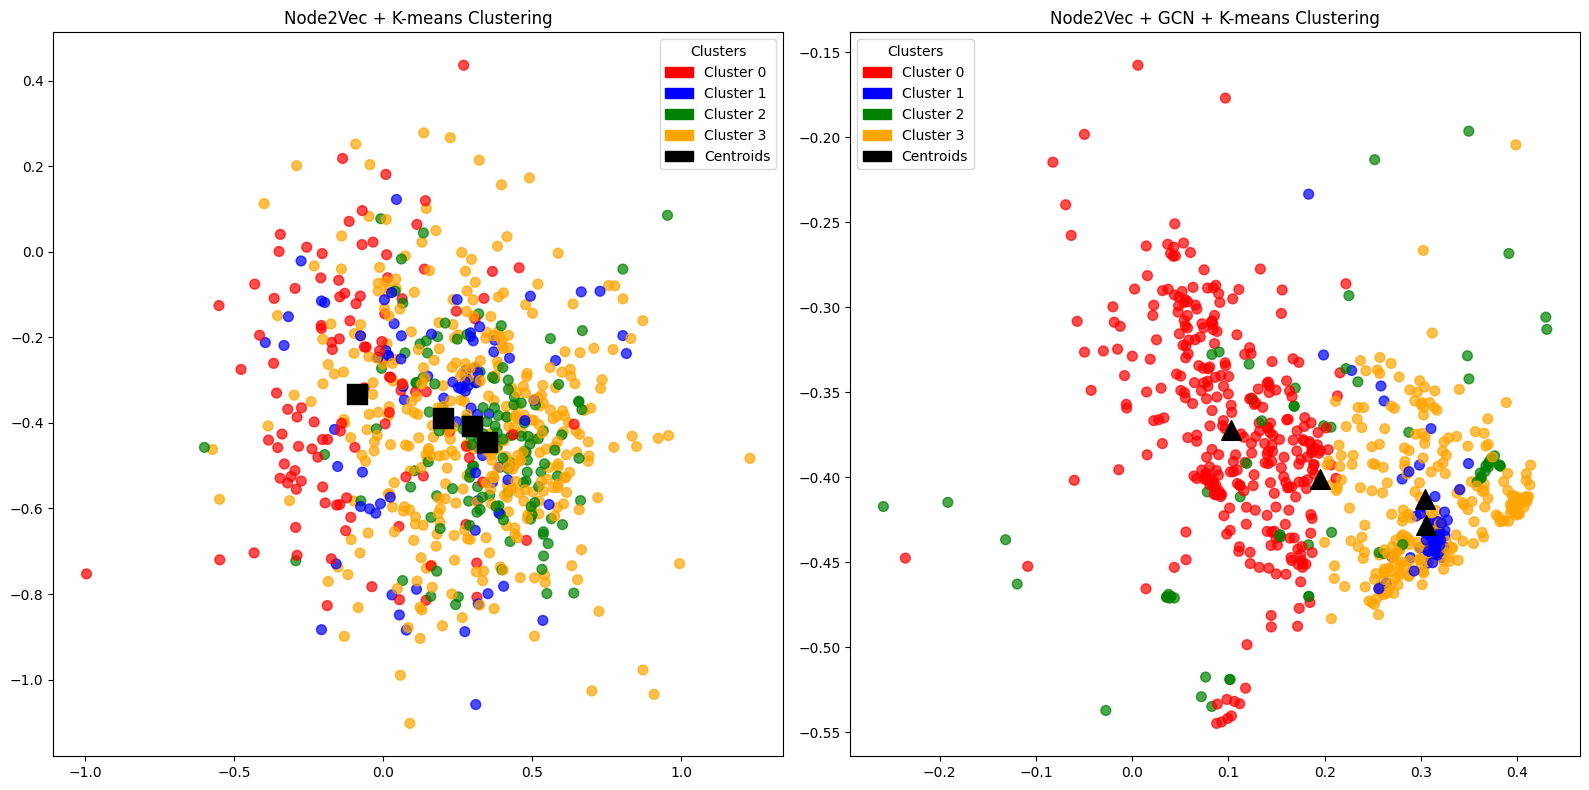

In [ ]:
# Merge clustering results (already based on 'Node ID')
df_merged1 = pd.merge(df_node2vec_kmeans, df_gcn_kmeans, on='Node ID')

# embedding files don’t have 'Node ID', we align by index:
df_merged1['Node2Vec_embeddings'] = df_embeddings_node2vec.values.tolist()  # Add Node2Vec embeddings to merged dataframe
df_merged1['GCN_embeddings'] = df_embeddings_gcn.values.tolist()  # Add GCN embeddings to merged dataframe

# Extract cluster labels for each method
node2vec_kmeans_labels = df_merged1['Node2Vec_Kmeans_Cluster'].values
gcn_kmeans_labels = df_merged1['GCN_Kmeans_Cluster'].values

# Extract embeddings for plotting
node_embeddings_node2vec = np.array(df_merged1['Node2Vec_embeddings'].tolist())
node_embeddings_gcn = np.array(df_merged1['GCN_embeddings'].tolist())

# Ensure that all lengths are consistent for plotting
min_len = min(len(node2vec_kmeans_labels), len(gcn_kmeans_labels), node_embeddings_node2vec.shape[0], node_embeddings_gcn.shape[0])

# Slice arrays to the same length
node_embeddings_node2vec = node_embeddings_node2vec[:min_len]
node2vec_kmeans_labels = node2vec_kmeans_labels[:min_len]
node_embeddings_gcn = node_embeddings_gcn[:min_len]
gcn_kmeans_labels = gcn_kmeans_labels[:min_len]

# Define cluster colors (extend if needed)
cluster_colors = ['red', 'blue', 'green', 'orange']

# Visualization
fig, axs = plt.subplots(1, 2, figsize=(16, 8))



# 1. Node2Vec + K-means Clusters
unique_labels_n2v = np.unique(node2vec_kmeans_labels)
axs[0].scatter(node_embeddings_node2vec[:, 0], node_embeddings_node2vec[:, 1],
               c=[cluster_colors[label % len(cluster_colors)] for label in node2vec_kmeans_labels], s=50, alpha=0.7)
# Compute and plot centroids
centroids_n2v = np.array([node_embeddings_node2vec[node2vec_kmeans_labels == label].mean(axis=0) for label in unique_labels_n2v])
axs[0].scatter(centroids_n2v[:, 0], centroids_n2v[:, 1], marker='s', s=200, c='black', label='Centroids')
axs[0].set_title("Node2Vec + K-means Clustering")
# Add legend
node2vec_legend = [mpatches.Patch(color=cluster_colors[label % len(cluster_colors)], label=f'Cluster {label}') for label in unique_labels_n2v]
axs[0].legend(handles=node2vec_legend + [mpatches.Patch(color='black', label='Centroids')], title="Clusters", loc="best")

# 2. Node2Vec + GCN + K-means Clusters
unique_labels_gcn = np.unique(gcn_kmeans_labels)
axs[1].scatter(node_embeddings_gcn[:, 0], node_embeddings_gcn[:, 1],
               c=[cluster_colors[label % len(cluster_colors)] for label in gcn_kmeans_labels], s=50, alpha=0.7)
# Compute and plot centroids
centroids_gcn = np.array([node_embeddings_gcn[gcn_kmeans_labels == label].mean(axis=0) for label in unique_labels_gcn])
axs[1].scatter(centroids_gcn[:, 0], centroids_gcn[:, 1], marker='^', s=200, c='black', label='Centroids')
axs[1].set_title("Node2Vec + GCN + K-means Clustering")
# Add legend
gcn_legend = [mpatches.Patch(color=cluster_colors[label % len(cluster_colors)], label=f'Cluster {label}') for label in unique_labels_gcn]
axs[1].legend(handles=gcn_legend + [mpatches.Patch(color='black', label='Centroids')], title="Clusters", loc="best")

plt.tight_layout()
plt.savefig('community_comparison.png')
print("Visualization saved as 'community_comparison.png'")

plt.show()